# AudioProtoPNet Inference Tutorial

Welcome to the **AudioProtoPNet** inference tutorial! This notebook shows you how to perform audio classification using pre-trained [AudioProtoPNet](https://github.com/DBD-research-group/AudioProtoPNet) models. These models are trained to identify bird species from audio recordings.

## About AudioProtoPNet Models
AudioProtoPNet is a prototype-based neural network architecture. Here, each class in the dataset has a specified number of prototypes that help the model discern audio features relevant to identifying that class.

There are four variants of AudioProtoPNet models:
- **AudioProtoPNet-1**: 1 prototype per class (9,736 total prototypes)
- **AudioProtoPNet-5**: 5 prototypes per class (48,680 total prototypes)
- **AudioProtoPNet-10**: 10 prototypes per class (97,360 total prototypes)
- **AudioProtoPNet-20**: 20 prototypes per class (194,720 total prototypes)

In this notebook, we demonstrate how to load the model, preprocess audio data, and generate predictions. **By default, we now use** AudioProtoPNet-20, but you can switch to any of the four variants by adjusting the relevant checkpoint path and number of prototypes.

For further insights into the model’s architecture and evaluation, please refer to the original research paper available [here](https://www.sciencedirect.com/science/article/pii/S1574954125000901).

## Key Points in This Tutorial
1. **Resampling**: We standardize audio to a 32 kHz sampling rate.
2. **Spectrogram Generation**: We convert the audio wave into a spectrogram using short-time Fourier transform (STFT) and Mel scaling.
3. **Normalization (z-standardization)**: We subtract a mean and divide by a standard deviation, calculated from the training data.
4. **Model Flexibility**: Although the model was trained on 5-second clips, it can be applied to audio of arbitrary length.

> **Important**: The spectrogram parameters shown here must be used **exactly** (e.g., `n_fft`, `hop_length`, `n_mels`, `n_stft`, and the standardization values). Changing these parameters can lead to performance degradation.

Let's get started!

In [1]:
# all the necessary installs to run a AudioProtoNet model
# !pip install transformers
# !pip install librosa
# !pip install torchaudio
# !pip install matplotlib

In [2]:
%%capture
from transformers import AutoFeatureExtractor, AutoModelForSequenceClassification
import librosa
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
variant = 20

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(f"DBD-research-group/AudioProtoPNet-{variant}-BirdSet-XCL", trust_remote_code=True)
model.eval();

## Loading an Example Birdsong

In [5]:
# 'librosa.ex' loads a built-in example audio of a European Robin.
sample_rate = 32000
audio_path = librosa.ex('robin')

label = "eurrob1"  # The eBird label for the European Robin.

# Load the audio file into 'audio' with our chosen sample_rate of 32 kHz.
audio, sample_rate = librosa.load(audio_path, sr=sample_rate)
Audio(audio, rate=sample_rate)

#### Visualizing the Audio Waveform

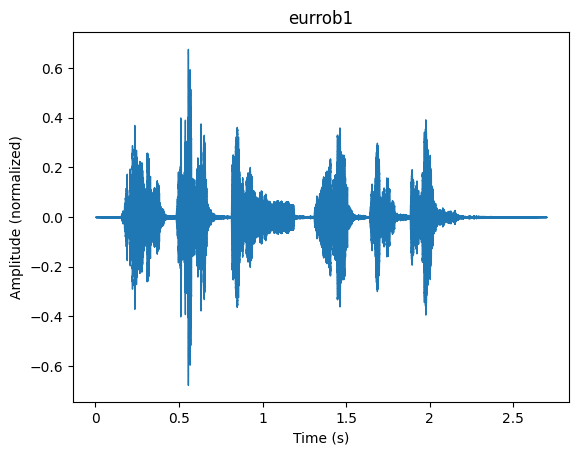

In [6]:
librosa.display.waveshow(y=audio, sr=sample_rate)
plt.title(label)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.show()

## Converting the Audio Signal into a Spectrogram

In order to use the AudioProtoPNet model, we must convert the raw audio waveform into a Mel-scaled spectrogram. The steps we use are:

1. **Spectrogram Transformation** (`transforms.Spectrogram`):
   - Uses STFT with a specific `n_fft` (window size) and `hop_length` (stride).
2. **Mel Scaling** (`transforms.MelScale`):
   - Converts frequencies to the Mel scale.
3. **dB Conversion** (`augmentations.PowerToDB()`):
   - Applies a logarithmic transform to the power spectrogram.
4. **Z-Standardization**:
   - We subtract a mean and divide by a standard deviation. These values (`mean` and `std`) come from the training data statistics.

Although the AudioProtoPNet was trained on 5-second clips, **you can use audio of any length**. Just note that the model processes the entire spectrogram.

The parameters for preprocessing below (e.g., `n_fft=2048`, `hop_length=256`, `n_mels=256`, `n_stft=1025`, `mean=-13.369`, `std=13.162`) **must** be used. Changing them may result in decreased performance.

> This spectrogram conversion is provided by the corresponding FeatureExtractor that can be loaded from the same huggingface model, via the `AutoFeatureExtractor`.

In [7]:
feature_extractor = AutoFeatureExtractor.from_pretrained(f"DBD-research-group/AudioProtoPNet-{variant}-BirdSet-XCL", trust_remote_code=True)

In [8]:
mel_spec_norm = feature_extractor(audio)

#### Visualizing the Spectrogram

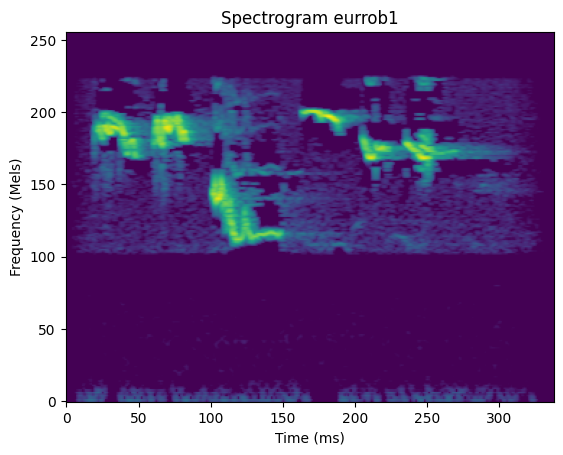

In [9]:
plt.imshow(mel_spec_norm[0,0], origin='lower')
plt.title('Spectrogram ' + label)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Mels)')
plt.show()

In [10]:
outputs = model(mel_spec_norm)

## Model hidden states
The last hidden state or all hidden states can be obtained with the `AutoModelForSequenceClassification`.
A pooled version can be obtained by using the `AutoModel` class and accessing the `pooler_output`.

In [11]:
# access the unpooled last hidden state
outputs["last_hidden_state"].shape

torch.Size([1, 1024, 8, 10])

## Classifying the Bird Species
Now that we have our preprocessed spectrogram, we can feed it into the model and obtain a prediction.

In [12]:

probabilities = torch.sigmoid(outputs[0]).detach()

In [13]:
# get the top 5 predictions by confidence
top_n_probs, top_n_indices = torch.topk(probabilities, k=5, dim=-1)

In [14]:
# model class mappings from, ebird code -> class id, and vice versa
label2id = model.config.label2id
id2label = model.config.id2label

In [15]:
print(f'Selected species with confidence:')
print(f"{label:<7} - {probabilities[:, label2id[label]].item():.2%}")
print("Top 5 Predictions with confidence:")
for idx, conf in zip(top_n_indices.squeeze(), top_n_probs.squeeze()):
    print(f"{id2label[idx.item()]:<7} - {conf:.2%}")

Selected species with confidence:
eurrob1 - 65.40%
Top 5 Predictions with confidence:
eurrob1 - 65.40%
blutit  - 34.11%
eugplo  - 33.66%
sablar2 - 33.50%
dunnoc1 - 32.35%
